### Ecommerce Shop — Market Basket Analysis

The goal of this analysis is to understand which products are purchased together and identify meaningful associations between items. By performing Market Basket Analysis, we aim to:
- detect patterns in customer purchasing behavior
- discover frequently co-purchased products
- identify strong association rules
- improve product placement, recommendations, and cross-selling strategies

This analysis helps an e-commerce business better understand customer shopping habits and optimize the catalog, marketing campaigns, and personalized offers.

In [20]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

### Step 1 Dataset overview

In [4]:
df = pd.read_csv('.//data/data-2.csv')

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [28]:
print("=" * 50)
print("E-COMMERCE SHOP DATA OVERVIEW")
print("=" * 50)
print()

print(f"Columns ({len(df.columns)}): {list(df.columns)}")

memory_usage = df.memory_usage(deep=True).sum() / (1024**2)
print(f"Memory Usage: {memory_usage:.2f} MB")

null_values = df.isna().sum().sum()
print(f"Total Missing Values: {null_values}")

duplicated_values = df.duplicated().sum()
print(f"Total Duplicated Rows: {duplicated_values}")

print(f"Dataset Shape: {df.shape}")
print(f"Total records: {len(df['InvoiceNo'])}")
print(f"Unique transactions: {len(df['InvoiceNo'].unique())}")
print(f"Total customers count: {len(df['CustomerID'].unique())}")
print(f"Total countrys count: {len(df['Country'].unique())}")
print(f"Total countrys: {df['Country'].unique()}")


print()

print("=" * 50)
print("UNIQUE VALUES FOR EACH COLUMN")
print("=" * 50)

for c, n in df.nunique().items():
    print(f"{c} => {n} unique values.")

print()

print("=" * 50)
print("NULL VALUES FOR EACH COLUMN")
print("=" * 50)

for c, n in df.isnull().sum().sort_values(ascending=False).items():
    print(f"{c} => {n} null values.")

E-COMMERCE SHOP DATA OVERVIEW

Columns (8): ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
Memory Usage: 131.34 MB
Total Missing Values: 0
Total Duplicated Rows: 0
Dataset Shape: (401604, 8)
Total records: 401604
Unique transactions: 22190
Total customers count: 4372
Total countrys count: 37
Total countrys: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Greece' 'Singapore' 'Lebanon'
 'United Arab Emirates' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Unspecified' 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'RSA']

UNIQUE VALUES FOR EACH COLUMN
InvoiceNo => 22190 unique values.
StockCode => 3684 unique values.
Description => 3896 unique values.
Quantity => 436 unique values.
InvoiceDate => 20460 unique values.
UnitPrice =>

<Figure size 1600x600 with 0 Axes>

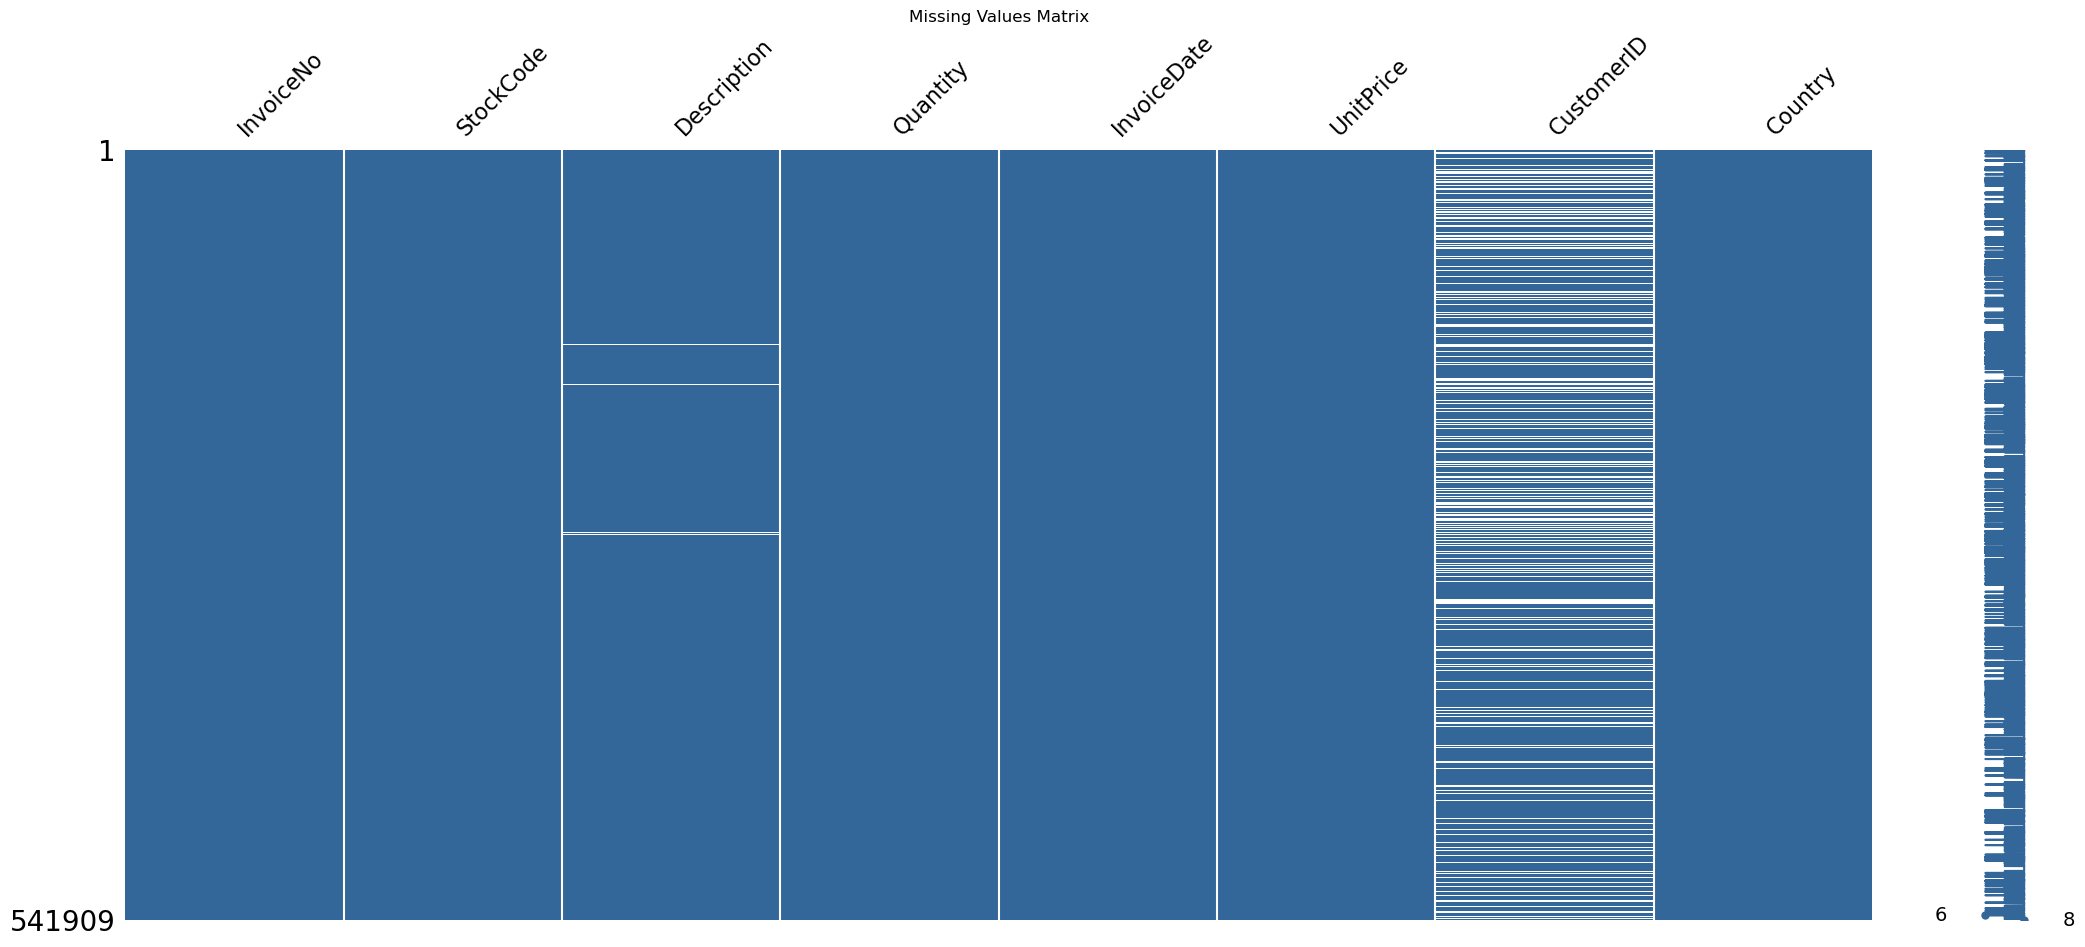

In [21]:
figsize = (16, 6)
color = (0.2, 0.4, 0.6)

plt.figure(figsize=figsize)
msno.matrix(df, color=color)
plt.title("Missing Values Matrix")
plt.savefig("missing_values_matrix.png", dpi=300)
plt.show()

### Step 2. Dataset cleaning

In [24]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [25]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Step 3. Creating revenue for each transaction

Revenue = Quantity * UnitPrice

In [30]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']

In [31]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


### Step 4. Basket analysis fo find association between producst

In [36]:
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth, association_rules

df = df[df['Quantity'] > 0]

product_counts = df.groupby('Description')['InvoiceNo'].nunique()
common_products = product_counts[product_counts >= 50].index  # products in at least 50 invoices
df = df[df['Description'].isin(common_products)]

basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

basket = basket.astype(bool)

frequent_itemsets = fpgrowth(basket, min_support=0.01, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('lift', ascending=False).head())

                                           antecedents  \
926  (REGENCY TEA PLATE GREEN , REGENCY TEA PLATE R...   
931                           (REGENCY TEA PLATE PINK)   
928  (REGENCY TEA PLATE PINK, REGENCY TEA PLATE ROS...   
929                         (REGENCY TEA PLATE GREEN )   
923                           (REGENCY TEA PLATE PINK)   

                                           consequents   support  confidence  \
926                           (REGENCY TEA PLATE PINK)  0.010100    0.807860   
931  (REGENCY TEA PLATE GREEN , REGENCY TEA PLATE R...  0.010100    0.825893   
928                         (REGENCY TEA PLATE GREEN )  0.010100    0.939086   
929  (REGENCY TEA PLATE PINK, REGENCY TEA PLATE ROS...  0.010100    0.685185   
923                         (REGENCY TEA PLATE GREEN )  0.011028    0.901786   

          lift  
926  66.060609  
931  66.060609  
928  63.708310  
929  63.708310  
923  61.177811  


In [37]:
rules_filtered = rules[(rules['lift'] > 5) & (rules['confidence'] > 0.7)]
rules_filtered.sort_values('lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
931,(REGENCY TEA PLATE PINK),"(REGENCY TEA PLATE GREEN , REGENCY TEA PLATE R...",0.012229,0.012502,0.010100,0.825893,66.060609,1.0,0.009947,5.671783,0.997055,0.690299,0.823689,0.816877
926,"(REGENCY TEA PLATE GREEN , REGENCY TEA PLATE R...",(REGENCY TEA PLATE PINK),0.012502,0.012229,0.010100,0.807860,66.060609,1.0,0.009947,5.140899,0.997331,0.690299,0.805481,0.816877
928,"(REGENCY TEA PLATE PINK, REGENCY TEA PLATE ROS...",(REGENCY TEA PLATE GREEN ),0.010755,0.014740,0.010100,0.939086,63.708310,1.0,0.009941,16.174678,0.995005,0.656028,0.938175,0.812136
923,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN ),0.012229,0.014740,0.011028,0.901786,61.177811,1.0,0.010848,10.031734,0.995832,0.691781,0.900316,0.824967
922,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE PINK),0.014740,0.012229,0.011028,0.748148,61.177811,1.0,0.010848,3.922032,0.998371,0.691781,0.745030,0.824967
618,(POPPY'S PLAYHOUSE LIVINGROOM ),"(POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE ...",0.013758,0.013867,0.010155,0.738095,53.227128,1.0,0.009964,3.765235,0.994900,0.581250,0.734412,0.735189
615,"(POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE ...",(POPPY'S PLAYHOUSE LIVINGROOM ),0.013867,0.013758,0.010155,0.732283,53.227128,1.0,0.009964,3.683905,0.995010,0.581250,0.728549,0.735189
919,(REGENCY SUGAR BOWL GREEN),(REGENCY MILK JUG PINK ),0.014631,0.014850,0.011246,0.768657,51.762813,1.0,0.011029,4.258392,0.995243,0.616766,0.765170,0.763005
918,(REGENCY MILK JUG PINK ),(REGENCY SUGAR BOWL GREEN),0.014850,0.014631,0.011246,0.757353,51.762813,1.0,0.011029,4.060914,0.995463,0.616766,0.753750,0.763005
927,"(REGENCY TEA PLATE GREEN , REGENCY TEA PLATE P...",(REGENCY TEA PLATE ROSES ),0.011028,0.017907,0.010100,0.915842,51.144727,1.0,0.009902,11.669577,0.991381,0.536232,0.914307,0.739933


In [38]:
strong_rules = rules[(rules['lift'] > 5) & (rules['confidence'] > 0.7)]

strong_rules = strong_rules.sort_values('lift', ascending=False)

for i, row in strong_rules.head(10).iterrows():
    antecedent = ', '.join(list(row['antecedents']))
    consequent = ', '.join(list(row['consequents']))
    print(f"If a customer buys [{antecedent}], they are likely to buy [{consequent}] "
          f"(support={row['support']:.2f}, confidence={row['confidence']:.2f}, lift={row['lift']:.2f})")

If a customer buys [REGENCY TEA PLATE PINK], they are likely to buy [REGENCY TEA PLATE GREEN , REGENCY TEA PLATE ROSES ] (support=0.01, confidence=0.83, lift=66.06)
If a customer buys [REGENCY TEA PLATE GREEN , REGENCY TEA PLATE ROSES ], they are likely to buy [REGENCY TEA PLATE PINK] (support=0.01, confidence=0.81, lift=66.06)
If a customer buys [REGENCY TEA PLATE PINK, REGENCY TEA PLATE ROSES ], they are likely to buy [REGENCY TEA PLATE GREEN ] (support=0.01, confidence=0.94, lift=63.71)
If a customer buys [REGENCY TEA PLATE PINK], they are likely to buy [REGENCY TEA PLATE GREEN ] (support=0.01, confidence=0.90, lift=61.18)
If a customer buys [REGENCY TEA PLATE GREEN ], they are likely to buy [REGENCY TEA PLATE PINK] (support=0.01, confidence=0.75, lift=61.18)
If a customer buys [POPPY'S PLAYHOUSE LIVINGROOM ], they are likely to buy [POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE BEDROOM ] (support=0.01, confidence=0.74, lift=53.23)
If a customer buys [POPPY'S PLAYHOUSE KITCHEN, POPPY

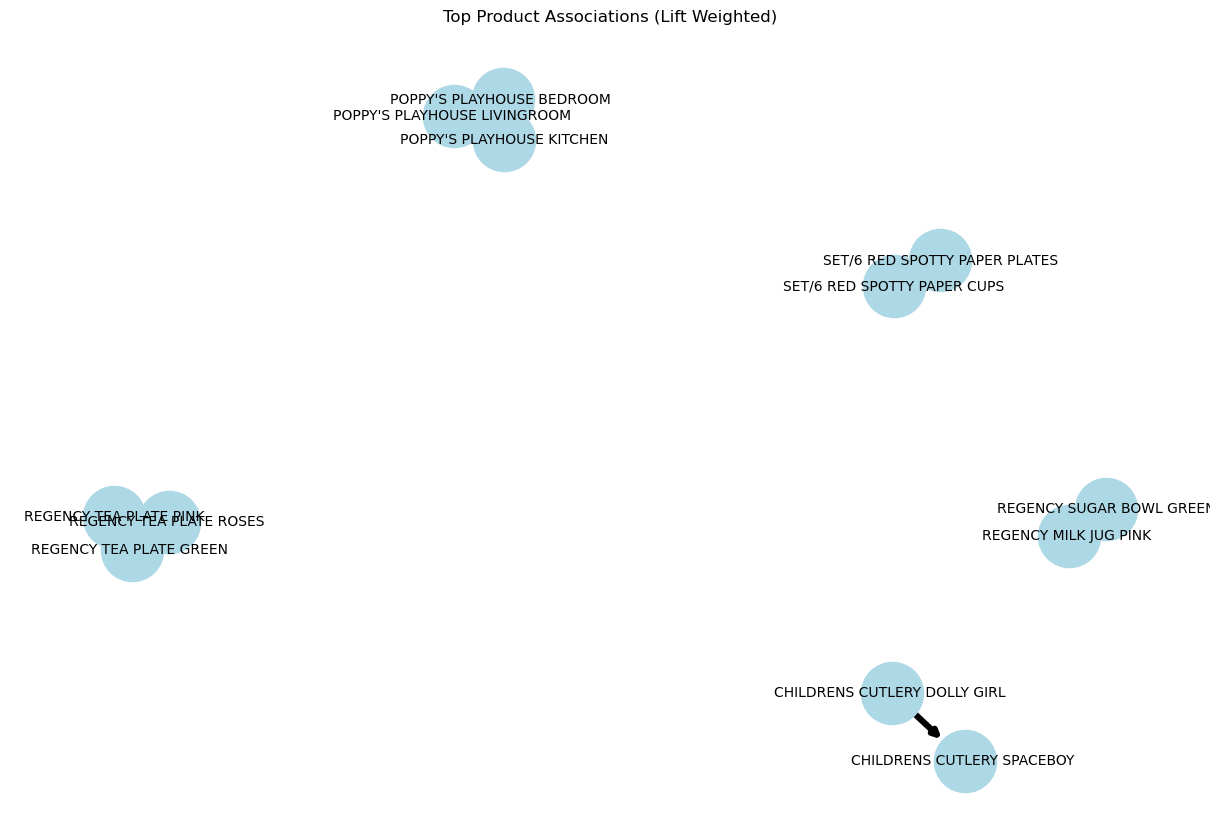

In [40]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

top_rules = strong_rules.head(20)
for _, row in top_rules.iterrows():
    for ant in row['antecedents']:
        for con in row['consequents']:
            G.add_edge(ant, con, weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1)
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, width=[w/10 for w in weights])
plt.title("Top Product Associations (Lift Weighted)")
plt.savefig("relation-graph.png", dpi=301)
plt.show()